In [76]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd
import os
import emcee
import corner
from getdist import plots, gaussian_mixtures, MCSamples

# SNe Ia Data & Functions

In [77]:
os.listdir()
os.listdir('Pantheon_SNeIa_dataset/')

['lcparam_DS17f.txt']

In [78]:
#binned Pantheon SNe Ia data
full_data = pd.read_csv('Pantheon_SNeIa_dataset/lcparam_DS17f.txt',sep=' ')

redshift = full_data['zcmb']
appmag = full_data['mb']
appmag_unc = full_data['dmb']

#absolute magnitude for Type 1a SNe
absmag = -19.25

#distance modulus = m - M
distmod = appmag - absmag
distmod.shape
distmod_unc = appmag_unc

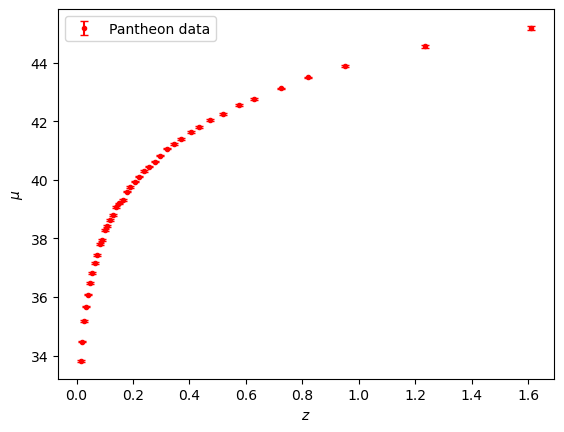

In [79]:
plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

In [80]:
H0 = 70000 #Hubble param today in m/s/Mpc (in km/s/Mpc its 70)
ls = 299792458 #speed of light in m/s

def integrand(z,Omr0,Omm0,Omk0,Oml0):
    res = 1./np.sqrt(Omr0*(1+z)**4 + Omm0*(1+z)**3 + Omk0*(1+z)**2 + Oml0)
    return res

def dL(z,Omr0,Omm0,Omk0,Oml0):
    #luminosity distance in Mpc
    integr = integrate.quad(integrand, 0, z, args=(Omr0,Omm0,Omk0,Oml0))
    if Omk0 == 0:
        return (1+z)*ls*integr[0]/H0
    if Omk0 < 0: #equiv to k>0; closed Universe
        return (1/np.sqrt(-Omk0))*(1+z)*ls*np.sin(np.sqrt(-Omk0)*integr[0])/H0
    if Omk0 > 0: #equiv to k<0; open Universe
        return (1/np.sqrt(Omk0))*(1+z)*ls*np.sinh(np.sqrt(Omk0)*integr[0])/H0

def dist_mod(lum_dist):
    res = 5.*np.log10(lum_dist) + 25.
    return res

def dLvect(z,Omr0,Omm0,Omk0,Oml0):
    #luminosity distance in Mpc
    length = len(z)
    res = []
    for i in range(length):
        integr = integrate.quad(integrand, 0, z[i], args=(Omr0,Omm0,Omk0,Oml0))
        if Omk0 == 0:
            res.append((1+z[i])*ls*integr[0]/H0)
        if Omk0 < 0: #equiv to k>0; closed Universe
            res.append((1/np.sqrt(-Omk0))*(1+z[i])*ls*np.sin(np.sqrt(-Omk0)*integr[0])/H0)
        if Omk0 > 0: #equiv to k<0; open Universe
            res.append((1/np.sqrt(Omk0))*(1+z[i])*ls*np.sinh(np.sqrt(Omk0)*integr[0])/H0)
    return res

In [81]:
# Define the log_likelihood function
def log_likelihood_SNe(params):
    Omr0, Omm0, Omk0, Oml0 = params
    theoretical_dm = dist_mod(dLvect(redshift, Omr0, Omm0, Omk0, Oml0))
    return -0.5*np.sum(((distmod.values - theoretical_dm)/distmod_unc.values)**2 + np.log(2*np.pi*distmod_unc**2))

# CC Data & Functions

In [82]:
os.listdir()
os.listdir('CC_dataset/')

['CC_data.xlsx']

In [83]:
#CC data
full_data_CC = pd.read_excel('CC_dataset/CC_data.xlsx')

redshift_CC = full_data_CC['redshift']
Hub = full_data_CC['H(z)']
Hub_unc = full_data_CC['sigma']

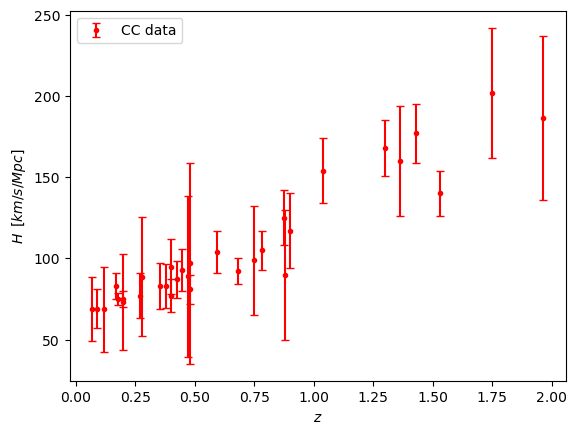

In [84]:
plt.figure()
plt.errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
plt.xlabel('$z$')
plt.ylabel('$H\,\,\,[km/s/Mpc]$')
plt.legend()
plt.show()

In [85]:
H0_av = 70
def Hubble(z,Omr0,Omm0,Omk0,Oml0):
    res = H0_av*np.sqrt(Omr0*(1+z)**4 + Omm0*(1+z)**3 + Omk0*(1+z)**2 + Oml0)
    return res

In [86]:
# Define the log_likelihood function
def log_likelihood_CC(params):
    Omr0, Omm0, Omk0, Oml0 = params
    theoretical_Hub = Hubble(redshift_CC, Omr0, Omm0, Omk0, Oml0)
    return -0.5*np.sum(((Hub.values - theoretical_Hub)/Hub_unc.values)**2 + np.log(2*np.pi*Hub_unc.values**2))

# CMB Distance Priors

In [87]:
ls_av = 299792.458 #lightspeed in km/s
z_CMB = 1089

#data
R = 1.7661
la = 301.7293
v_obs = np.array([R,la])
#print(v_obs)

#covariance matrix
C = 10**(-8)*np.array([[33483.54, -44417.15],[-44417.15, 4245661.67]])
C_inv = np.linalg.inv(C)
#print(C_inv)

In [88]:
def Comov_dist(params):
    Omr0, Omm0, Omk0, Oml0 = params
    if Omk0 == 0:
        res = integrate.quad(integrand, 0, z_CMB, args=(Omr0,Omm0,Omk0,Oml0))[0]*ls_av/H0_av
    if Omk0 < 0: #equiv to k > 0
        res = (ls_av/H0_av)*(1/np.sqrt(np.abs(Omk0)))*np.sin(np.sqrt(np.abs(Omk0))*integrate.quad(integrand, 0, z_CMB, args=(Omr0,Omm0,Omk0,Oml0))[0])
    if Omk0 > 0: #equiv to k < 0
        res = (ls_av/H0_av)*(1/np.sqrt(np.abs(Omk0)))*np.sinh(np.sqrt(np.abs(Omk0))*integrate.quad(integrand, 0, z_CMB, args=(Omr0,Omm0,Omk0,Oml0))[0])
    return res

def Integr_Sound_hor(z,Omr0,Omm0,Omk0,Oml0):
    res = 1./np.sqrt((1 + 660/(1+z))*(Omr0*(1+z)**4 + Omm0*(1+z)**3 + Omk0*(1+z)**2 + Oml0))
    return res

def Sound_hor(params):
    Omr0, Omm0, Omk0, Oml0 = params
    res = integrate.quad(Integr_Sound_hor, z_CMB, np.inf, args=(Omr0,Omm0,Omk0,Oml0))[0]*ls_av/(np.sqrt(3)*H0_av)
    return res

def Dist_priors(params):
    Omr0, Omm0, Omk0, Oml0 = params
    R_theo = np.sqrt(Omm0)*H0_av*Comov_dist(params)/ls_av 
    la_theo = np.pi*Comov_dist(params)/Sound_hor(params)
    v_theo = np.array([R_theo,la_theo])
    return v_theo

In [89]:
def log_likelihood_CMB(params):
    Omr0, Omm0, Omk0, Oml0 = params
    v_theo = Dist_priors([Omr0, Omm0, Omk0, Oml0])
    return -0.5*np.matmul((v_theo-v_obs).transpose(),np.matmul(C_inv,v_theo-v_obs))

# BBN

In [90]:
#Our "data" is the hubble parameter for LambdaCDM at z=10^9
redshift_BBN = 10**9
HLCDM = H0_av*np.sqrt(5*10**(-5)*(1+redshift_BBN)**4)

In [91]:
# Define the log_likelihood function
def log_likelihood_BBN(params):
    Omr0, Omm0, Omk0, Oml0 = params
    theoretical_Hub = Hubble(redshift_BBN, Omr0, Omm0, Omk0, Oml0)
    return -0.5*((HLCDM - theoretical_Hub)/HLCDM)**2

In [92]:
#print(HLCDM)
#print(log_likelihood_BBN([5*10**(-5),0.3,0.01,0.78]))

# BAO

In [93]:
os.listdir()
os.listdir('BAO_dataset/')

['BAO_data.xlsx']

In [94]:
#BAO data
full_data_BAO = pd.read_excel('BAO_dataset/BAO_data.xlsx')

redshift_BAO = full_data_BAO['redshift']
Thetdeg = full_data_BAO['Theta [deg]']
Thetdeg_unc = full_data_BAO['sigma [deg]']

Thet = Thetdeg*np.pi/180 #change to radians
Thet_unc = Thetdeg_unc*np.pi/180 #change to radians

In [95]:
#Our observable with uncertainty
DA_rdrag = 1/((1+redshift_BAO)*Thet)
#DA_rdrag
DA_rdrag_unc = Thet_unc/((1+redshift_BAO)*Thet**2)
#DA_rdrag_unc

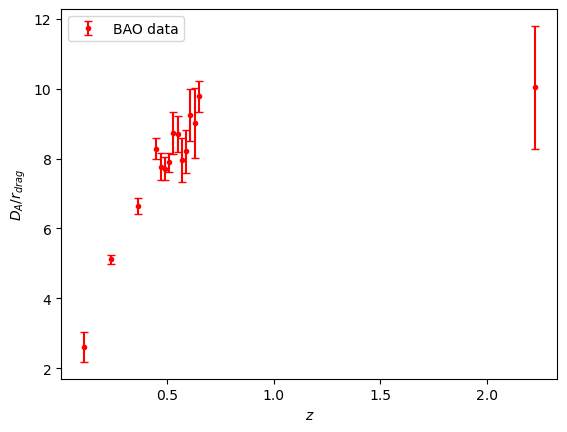

In [96]:
plt.figure()
plt.errorbar(redshift_BAO, DA_rdrag, yerr=DA_rdrag_unc, capsize=3, fmt='r.', label='BAO data')
plt.xlabel('$z$')
plt.ylabel('$D_A/r_{drag}$')
plt.legend()
plt.show()

In [97]:
z_drag = 1020.5

def Comov_dist_BAO(z,params):
    Omr0, Omm0, Omk0, Oml0 = params
    res = []
    for i in z:
        if Omk0 == 0:
            res.append(integrate.quad(integrand, 0, i, args=(Omr0,Omm0,Omk0,Oml0))[0]*ls_av/H0_av)
        if Omk0 < 0: #equiv to k > 0
            res.append((ls_av/H0_av)*(1/np.sqrt(np.abs(Omk0)))*np.sin(np.sqrt(np.abs(Omk0))*integrate.quad(integrand, 0, i, args=(Omr0,Omm0,Omk0,Oml0))[0]))
        if Omk0 > 0: #equiv to k < 0
            res.append((ls_av/H0_av)*(1/np.sqrt(np.abs(Omk0)))*np.sinh(np.sqrt(np.abs(Omk0))*integrate.quad(integrand, 0, i, args=(Omr0,Omm0,Omk0,Oml0))[0]))
    return res

def Drag_hor(params):
    Omr0, Omm0, Omk0, Oml0 = params
    res = integrate.quad(Integr_Sound_hor, z_drag, np.inf, args=(Omr0,Omm0,Omk0,Oml0))[0]*ls_av/(np.sqrt(3)*H0_av)
    return res

def DA(z,params):
    rdrag = Drag_hor(params)
    res = Comov_dist_BAO(z,params)/((1+z)*rdrag)
    return res
    

In [98]:
#DA([10**(-5),0.3,0.01,0.6])

In [99]:
def log_likelihood_BAO(params):
    Omr0, Omm0, Omk0, Oml0 = params
    DA_theo = DA(redshift_BAO,[Omr0, Omm0, Omk0, Oml0])
    return -0.5*np.sum(((DA_rdrag.values - DA_theo)/DA_rdrag_unc.values)**2 + np.log(2*np.pi*DA_rdrag_unc.values**2))

# MCMC

In [100]:
# Uniform log_prior
def log_prior(params):
    Omr0, Omm0, Omk0, Oml0 = params
    if 0.0 <= Omr0 <= 0.001 and 0.0 <= Omm0 <= 1.0 and -0.01 <= Omk0 <= 0.01 and 0.0 <= Oml0 <= 1.0:
        return -np.log(0.001*1*0.02*1)
    return -np.inf

In [101]:
def log_sum_late(params):
    # Compute the log-prior
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    llSNe = log_likelihood_SNe(params)
    llCC = log_likelihood_CC(params)
    llBAO = log_likelihood_BAO(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + llSNe + llCC + llBAO

In [102]:
#Product, resp. sum in logarithm form of likelihood and prior
def log_sum(params):
    # Compute the log-prior
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    llSNe = log_likelihood_SNe(params)
    llCC = log_likelihood_CC(params)
    llCMB = log_likelihood_CMB(params)
    llBBN = log_likelihood_BBN(params)
    llBAO = log_likelihood_BAO(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + llSNe + llCC + llCMB + llBBN + llBAO

In [103]:
# Set the number of dimensions (i.e. the number of parameters)
ndim = 4

# Set the number of walkers
nwalkers = 10

# Define the range of values for each parameter
theta_min = [0, 0, -0.01, 0]
theta_max = [0.001, 1, 0.01, 1]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
sampler_late = emcee.EnsembleSampler(nwalkers, ndim, log_sum_late, args=())

In [104]:
# Run the sampler for a specified number of iterations
n_iterations = 10000
sampler_late.run_mcmc(p0, n_iterations, progress=True)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:55<00:00, 21.04it/s]


State([[ 8.59478934e-05  3.18736037e-01 -7.86506206e-03  7.91855930e-01]
 [ 9.75858668e-05  2.90137693e-01  1.02191063e-03  8.32183059e-01]
 [ 9.75967871e-05  2.95886168e-01  3.29709109e-03  8.09921363e-01]
 [ 9.08847660e-05  3.21604972e-01  3.90292410e-03  7.73815888e-01]
 [ 8.54081830e-05  3.15344242e-01  1.10227089e-03  7.85270045e-01]
 [ 8.10932960e-05  3.36674528e-01 -6.85202062e-03  7.62395317e-01]
 [ 7.64458928e-05  3.16641088e-01  3.37262860e-03  7.75230696e-01]
 [ 8.97326740e-05  3.18715930e-01 -7.21823563e-03  7.95039207e-01]
 [ 9.09705323e-05  3.07725771e-01 -6.94852311e-03  8.04064722e-01]
 [ 9.10745353e-05  2.91144754e-01  8.23095928e-03  8.00653489e-01]], log_prob=[-48.12716998 -53.03736984 -49.57695802 -49.8478113  -48.29611334
 -50.31815581 -50.95118939 -49.17405636 -48.15143528 -50.72957672], blobs=None, random_state=('MT19937', array([4052731121, 3877443749,  645735872, 3937325371,  386752797,
       3634287175, 1865789025,  417255757, 1773315760, 2112331140,
        

In [105]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples_late = sampler_late.chain[:, :, :]
print(sampler_late.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 200
final_samples_late = samples_late[:,burnin:, :]
print(final_samples_late.shape)

(10, 10000, 4)
(10, 9800, 4)


(98000, 4)


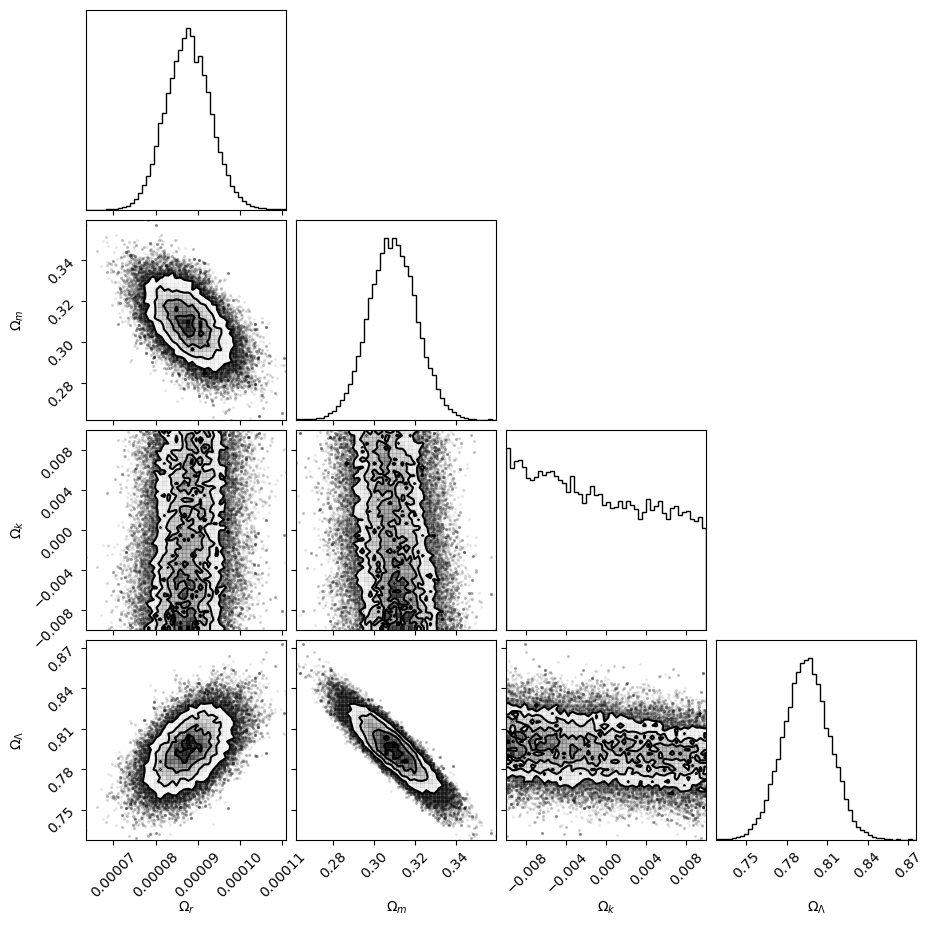

In [106]:
# Flatten the chain of samples
flat_samples_late = final_samples_late.reshape(-1, ndim)
print(flat_samples_late.shape)

# Plot the corner plot using the flattened samples
figure = corner.corner(flat_samples_late,bins=50, labels=['$\Omega_r$','$\Omega_m$','$\Omega_k$','$\Omega_\Lambda$'])

# Show the plot
plt.show()

Removed no burn in


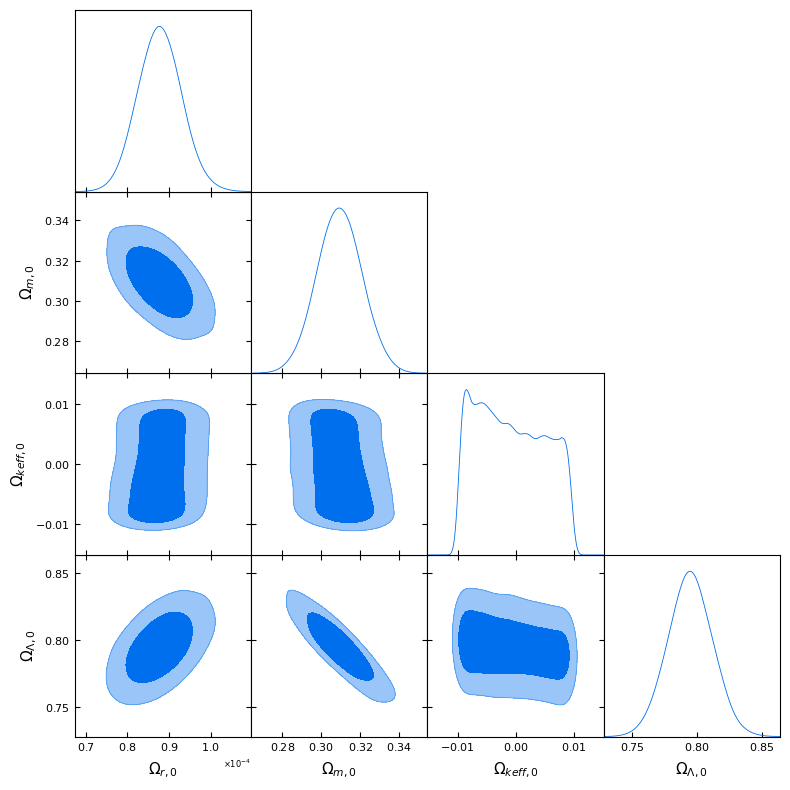

In [120]:
names_late = ['Omega_r','Omega_m', 'Omega_k', 'Omega_L']
labels_late =  ['\Omega_{r,0}','\Omega_{m,0}','\Omega_{keff,0}','\Omega_{\Lambda,0}']
samples_new_late = MCSamples(samples=np.array(flat_samples_late),names=names_late,labels=labels_late,label='SNe Ia + CC + BAO')
g = plots.get_subplot_plotter()
g.triangle_plot(samples_new_late, filled=True)

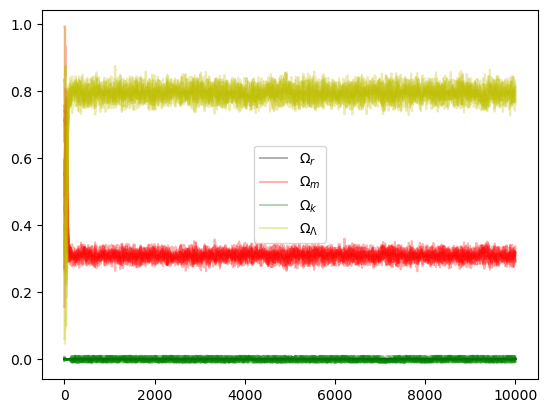

In [108]:
plt.figure()
plt.plot(samples_late[0,:,0].T, '-', color='k', alpha=0.3,label='$\Omega_r$')
plt.plot(samples_late[1:,:,0].T, '-', color='k', alpha=0.3)
plt.plot(samples_late[0,:,1].T, '-', color='r', alpha=0.3,label='$\Omega_m$')
plt.plot(samples_late[1:,:,1].T, '-', color='r', alpha=0.3)
plt.plot(samples_late[0,:,2].T, '-', color='g', alpha=0.3,label='$\Omega_k$')
plt.plot(samples_late[1:,:,2].T, '-', color='g', alpha=0.3)
plt.plot(samples_late[0,:,3].T, '-', color='y', alpha=0.3,label='$\Omega_\Lambda$')
plt.plot(samples_late[1:,:,3].T, '-', color='y', alpha=0.3)
plt.legend()
plt.show()

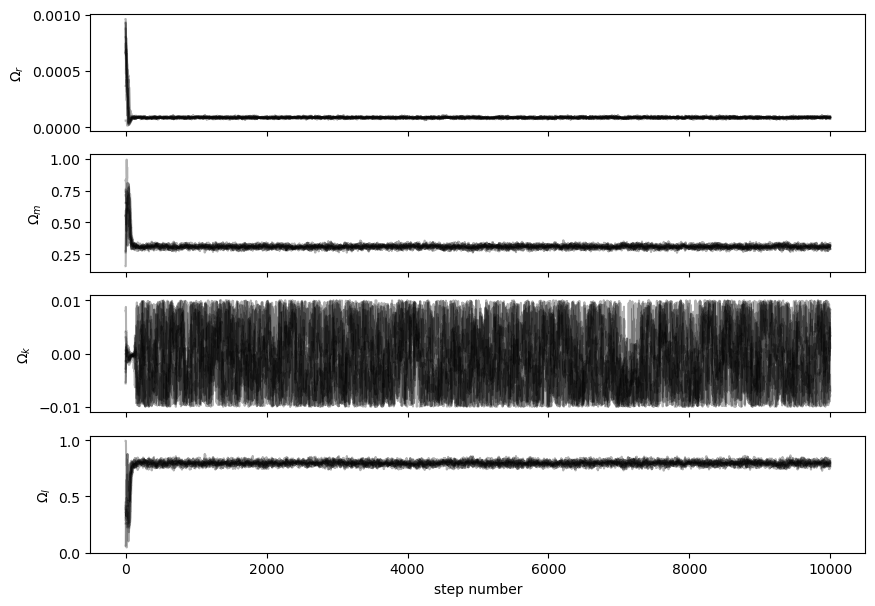

In [109]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_late = sampler_late.get_chain()
labels = ["$\Omega_r$", "$\Omega_m$","$\Omega_k$", "$\Omega_l$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler_late.chain[:,:,i].T, "k-", alpha=0.3)
    #ax.set_xlim(0, 10000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [110]:
sampler_late.chain[:,:,0].T.shape

(10000, 10)

In [111]:
#mean and std dev of Om_r
m1_late = np.mean(flat_samples_late[:,0])
std1_late = np.std(flat_samples_late[:,0])
print('Mean of Om_r = ',m1_late)
print('Std dev of Om_r = ',std1_late)

#mean and std dev of Om_m
m2_late = np.mean(flat_samples_late[:,1])
std2_late = np.std(flat_samples_late[:,1])
print('Mean of Om_m = ',m2_late)
print('Std dev of Om_m = ',std2_late)

#mean and std dev of Om_k
m3_late = np.mean(flat_samples_late[:,2])
std3_late = np.std(flat_samples_late[:,2])
print('Mean of Om_k = ',m3_late)
print('Std dev of Om_k = ',std3_late)

#mean and std dev of Om_l
m4_late = np.mean(flat_samples_late[:,3])
std4_late = np.std(flat_samples_late[:,3])
print('Mean of Om_l = ',m4_late)
print('Std dev of Om_l = ',std4_late)

Mean of Om_r =  8.776672721058193e-05
Std dev of Om_r =  5.30682685092816e-06
Mean of Om_m =  0.30929357588145096
Std dev of Om_m =  0.011651350818500394
Mean of Om_k =  -0.0007480497148006952
Std dev of Om_k =  0.005790125021971597
Mean of Om_l =  0.7947208955282032
Std dev of Om_l =  0.01731438452427944


C:\Users\armin\AppData\Local\Temp\ipykernel_9040\923630224.py:19: RuntimeWarning: divide by zero encountered in log10
  res = 5.*np.log10(lum_dist) + 25.


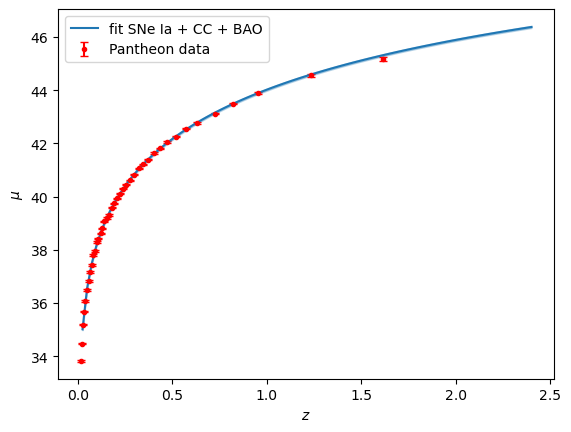

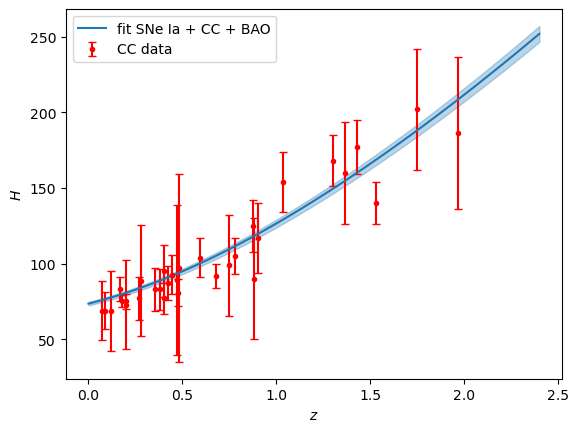

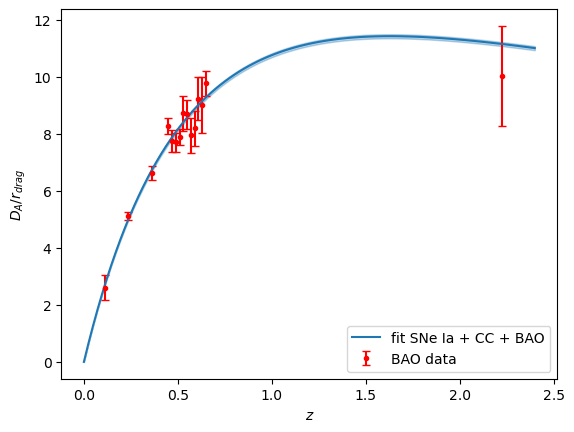

In [112]:
x = np.linspace(0,2.4,100)


y_SN_late = dist_mod(dLvect(x,m1_late,m2_late,m3_late,m4_late))
y_SN_late_plus = dist_mod(dLvect(x,m1_late+std1_late,m2_late+std2_late,m3_late+std3_late,m4_late+std4_late))
y_SN_late_minus = dist_mod(dLvect(x,m1_late-std1_late,m2_late-std2_late,m3_late-std3_late,m4_late-std4_late))
plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(x,y_SN_late,label='fit SNe Ia + CC + BAO')
plt.fill_between(x, y_SN_late_minus , y_SN_late_plus,color='C0', alpha=0.3)
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

y_CC_late = Hubble(x,m1_late,m2_late,m3_late,m4_late)
y_CC_late_plus = Hubble(x,m1_late+std1_late,m2_late+std2_late,m3_late+std3_late,m4_late+std4_late)
y_CC_late_minus = Hubble(x,m1_late-std1_late,m2_late-std2_late,m3_late-std3_late,m4_late-std4_late)
plt.figure()
plt.errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
plt.plot(x,y_CC_late,label='fit SNe Ia + CC + BAO')
plt.fill_between(x, y_CC_late_minus , y_CC_late_plus,color='C0', alpha=0.3)
plt.xlabel('$z$')
plt.ylabel('$H$')
plt.legend()
plt.show()

y_BAO_late = DA(x,[m1_late,m2_late,m3_late,m4_late])
y_BAO_late_plus = DA(x,[m1_late+std1_late,m2_late+std2_late,m3_late+std3_late,m4_late+std4_late])
y_BAO_late_minus = DA(x,[m1_late-std1_late,m2_late-std2_late,m3_late-std3_late,m4_late-std4_late])
plt.figure()
plt.errorbar(redshift_BAO, DA_rdrag, yerr=DA_rdrag_unc, capsize=3, fmt='r.', label='BAO data')
plt.plot(x,y_BAO_late,label='fit SNe Ia + CC + BAO')
plt.fill_between(x, y_BAO_late_minus , y_BAO_late_plus,color='C0', alpha=0.3)
plt.xlabel('$z$')
plt.ylabel('$D_A/r_{drag}$')
plt.legend()
plt.show()

# Comparison

In [113]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, args=())

# Run the sampler for a specified number of iterations
n_iterations = 10000
sampler.run_mcmc(p0, n_iterations, progress=True)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:22<00:00, 11.60it/s]


State([[8.98060335e-05 3.04480162e-01 8.68708708e-03 7.81458647e-01]
 [9.53802931e-05 3.09968079e-01 9.21120387e-04 7.86035989e-01]
 [9.41483026e-05 3.15829712e-01 4.80300328e-03 7.76702936e-01]
 [9.29907936e-05 2.99839395e-01 1.40493758e-03 8.09395607e-01]
 [9.14179314e-05 3.12167256e-01 9.39979667e-03 7.80746679e-01]
 [8.78666017e-05 2.94404321e-01 9.64638009e-03 8.02266783e-01]
 [8.68212843e-05 2.87714587e-01 9.22792677e-03 8.14861369e-01]
 [9.09430172e-05 3.07734638e-01 7.79058703e-03 7.81986969e-01]
 [9.20869467e-05 3.07446032e-01 5.68147587e-03 7.83036065e-01]
 [9.11967196e-05 3.05348563e-01 7.78214455e-03 8.00968048e-01]], log_prob=[-50.85658403 -52.96678297 -50.96026699 -52.59375108 -49.23772359
 -49.99576599 -52.62851541 -49.96517055 -50.52717453 -51.76784707], blobs=None, random_state=('MT19937', array([4052731121, 3877443749,  645735872, 3937325371,  386752797,
       3634287175, 1865789025,  417255757, 1773315760, 2112331140,
        680077240,  507107302, 4082221470, 20554

In [114]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples = sampler.chain[:, :, :]
print(sampler.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 200
final_samples = samples[:,burnin:, :]
print(final_samples.shape)

(10, 10000, 4)
(10, 9800, 4)


(98000, 4)
Removed no burn in


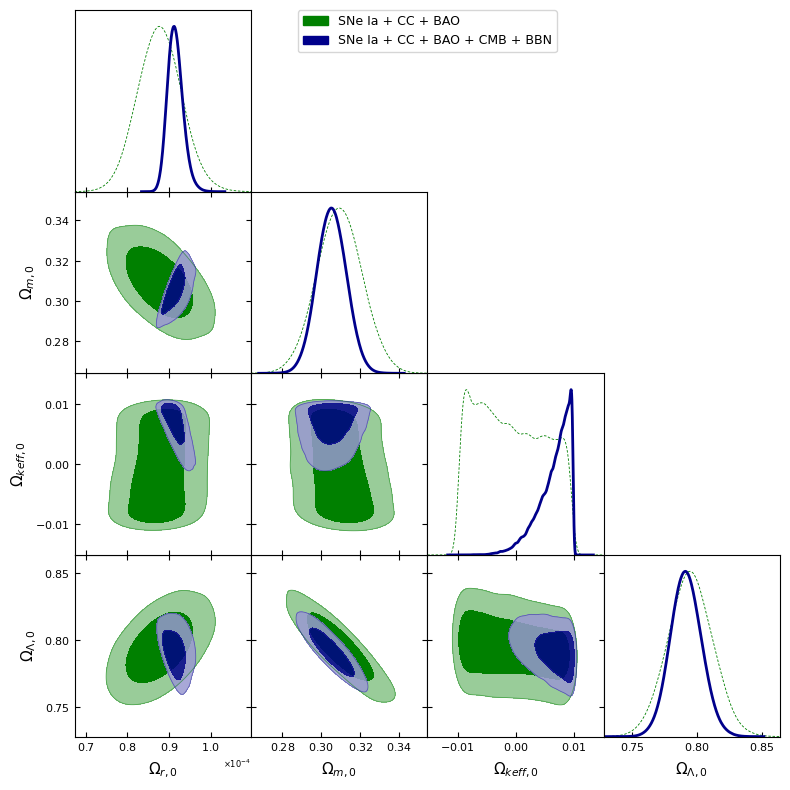

In [121]:
# Flatten the chain of samples
flat_samples = final_samples.reshape(-1, ndim)
print(flat_samples.shape)

names = ['Omega_r','Omega_m', 'Omega_k', 'Omega_L']
labels =  ['\Omega_{r,0}','\Omega_{m,0}','\Omega_{keff,0}','\Omega_{\Lambda,0}']
samples_new = MCSamples(samples=np.array(flat_samples),names=names,labels=labels,label='SNe Ia + CC + BAO + CMB + BBN')
g = plots.get_subplot_plotter()
#g.settings.alpha_filled_add=0.8
g.triangle_plot([samples_new_late,samples_new], filled=True, line_args=[{'ls':'--', 'color':'green'},{'lw':2, 'color':'darkblue'}],contour_colors=['green','darkblue'])
g.export('MCMC_triangle.pdf')

In [116]:
#mean and std dev of Om_r
m1 = np.mean(flat_samples[:,0])
std1 = np.std(flat_samples[:,0])
print('Mean of Om_r = ',m1)
print('Std dev of Om_r = ',std1)

#mean and std dev of Om_m
m2 = np.mean(flat_samples[:,1])
std2 = np.std(flat_samples[:,1])
print('Mean of Om_m = ',m2)
print('Std dev of Om_m = ',std2)

#mean and std dev of Om_k
m3 = np.mean(flat_samples[:,2])
std3 = np.std(flat_samples[:,2])
print('Mean of Om_k = ',m3)
print('Std dev of Om_k = ',std3)

#mean and std dev of Om_l
m4 = np.mean(flat_samples[:,3])
std4 = np.std(flat_samples[:,3])
print('Mean of Om_l = ',m4)
print('Std dev of Om_l = ',std4)

Mean of Om_r =  9.150467329616427e-05
Std dev of Om_r =  1.8848332620429504e-06
Mean of Om_m =  0.30525378993379954
Std dev of Om_m =  0.007567923746061522
Mean of Om_k =  0.006621564407988399
Std dev of Om_k =  0.0027753781227119055
Mean of Om_l =  0.7915127240962755
Std dev of Om_l =  0.01208100790949316


C:\Users\armin\AppData\Local\Temp\ipykernel_9040\923630224.py:19: RuntimeWarning: divide by zero encountered in log10
  res = 5.*np.log10(lum_dist) + 25.


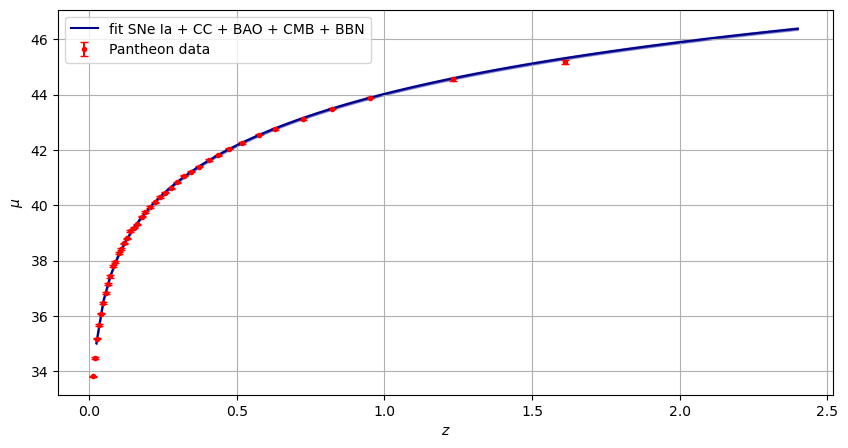

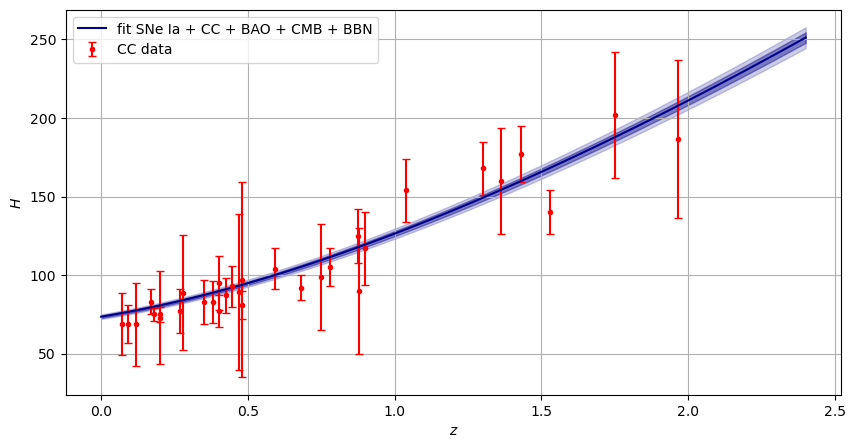

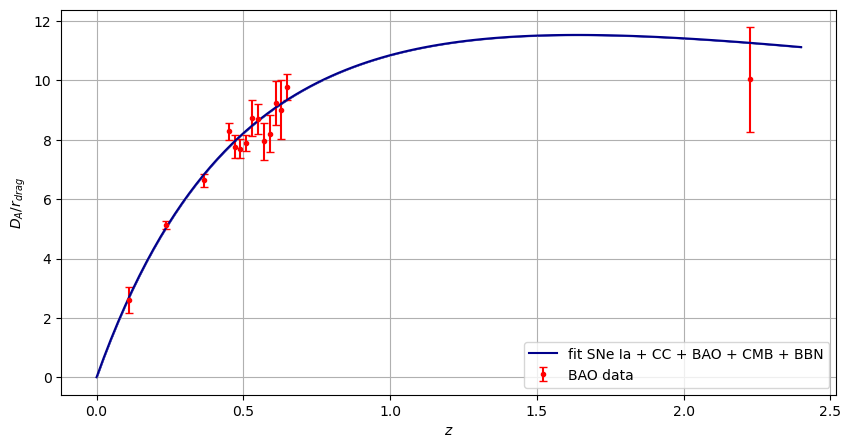

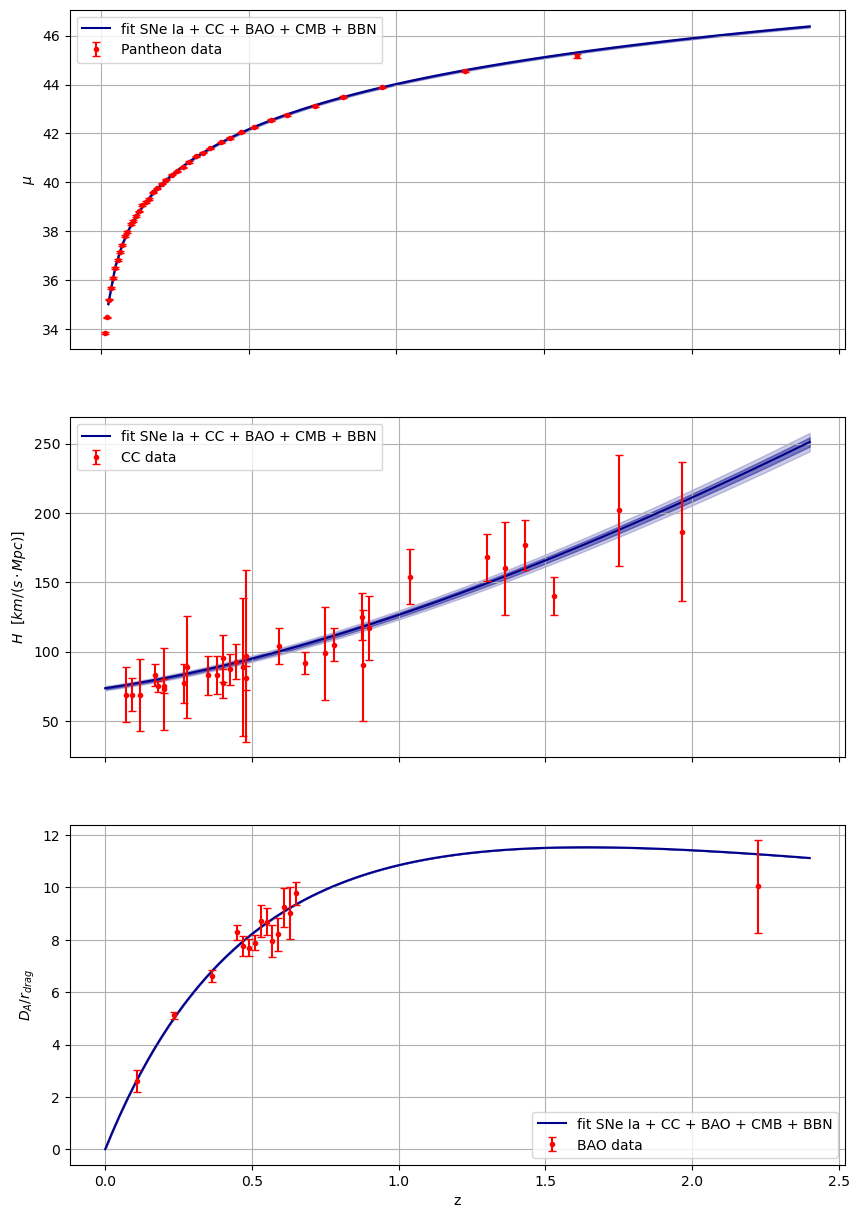

In [125]:
x = np.linspace(0,2.4,100)



y_SN = dist_mod(dLvect(x,m1,m2,m3,m4))
y_SN_plus = dist_mod(dLvect(x,m1+std1,m2+std2,m3+std3,m4+std4))
y_SN_minus = dist_mod(dLvect(x,m1-std1,m2-std2,m3-std3,m4-std4))
y_SN_pplus = dist_mod(dLvect(x,m1+2*std1,m2+2*std2,m3+2*std3,m4+2*std4))
y_SN_mminus = dist_mod(dLvect(x,m1-2*std1,m2-2*std2,m3-2*std3,m4-2*std4))

plt.figure(figsize=(10,5))
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
#plt.plot(x,y_SN_late,label='fit SNe Ia + CC + BAO',color='green',linestyle='--')
#plt.fill_between(x, y_SN_late_minus , y_SN_late_plus,color='C0', alpha=0.3)
plt.plot(x,y_SN,label='fit SNe Ia + CC + BAO + CMB + BBN',color='darkblue')
plt.fill_between(x, y_SN_minus , y_SN_plus,color='darkblue', alpha=0.4)
plt.fill_between(x, y_SN_mminus , y_SN_pplus,color='darkblue', alpha=0.2)
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.grid()
plt.savefig('distmod.pdf')
#plt.show()




y_CC = Hubble(x,m1,m2,m3,m4)
y_CC_plus = Hubble(x,m1+std1,m2+std2,m3+std3,m4+std4)
y_CC_minus = Hubble(x,m1-std1,m2-std2,m3-std3,m4-std4)
y_CC_pplus = Hubble(x,m1+2*std1,m2+2*std2,m3+2*std3,m4+2*std4)
y_CC_mminus = Hubble(x,m1-2*std1,m2-2*std2,m3-2*std3,m4-2*std4)

plt.figure(figsize=(10,5))
plt.errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
#plt.plot(x,y_CC_late,label='fit SNe Ia + CC + BAO',color='green',linestyle='--')
#plt.fill_between(x, y_CC_late_minus , y_CC_late_plus,color='C0', alpha=0.4)
plt.plot(x,y_CC,label='fit SNe Ia + CC + BAO + CMB + BBN',color='darkblue')
plt.fill_between(x, y_CC_minus , y_CC_plus,color='darkblue', alpha=0.4)
plt.fill_between(x, y_CC_mminus , y_CC_pplus,color='darkblue', alpha=0.2)
plt.xlabel('$z$')
plt.ylabel('$H$')
plt.legend()
plt.grid()
plt.savefig('Hubble.pdf')
#plt.show()




y_BAO = DA(x,[m1,m2,m3,m4])
y_BAO_plus = DA(x,[m1+std1,m2+std2,m3+std3,m4+std4])
y_BAO_minus = DA(x,[m1-std1,m2-std2,m3-std3,m4-std4])
y_BAO_pplus = DA(x,[m1+2*std1,m2+2*std2,m3+2*std3,m4+2*std4])
y_BAO_mminus = DA(x,[m1-2*std1,m2-2*std2,m3-2*std3,m4-2*std4])


plt.figure(figsize=(10,5))
plt.errorbar(redshift_BAO, DA_rdrag, yerr=DA_rdrag_unc, capsize=3, fmt='r.', label='BAO data')
#plt.plot(x,y_BAO_late,label='fit SNe Ia + CC + BAO',color='green',linestyle='--')
#plt.fill_between(x, y_BAO_late_minus , y_BAO_late_plus,color='C0', alpha=0.3)
plt.plot(x,y_BAO,label='fit SNe Ia + CC + BAO + CMB + BBN',color='darkblue')
plt.fill_between(x, y_BAO_minus , y_BAO_plus,color='darkblue', alpha=0.4)
plt.fill_between(x, y_BAO_mminus , y_BAO_pplus,color='darkblue', alpha=0.2)
plt.xlabel('$z$')
plt.ylabel('$D_A/r_{drag}$')
plt.legend()
plt.grid()
plt.savefig('DA_rdr.pdf')
#plt.show()

fig, axs = plt.subplots(3)
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0].plot(x,y_SN,label='fit SNe Ia + CC + BAO + CMB + BBN',color='darkblue')
axs[0].errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
axs[0].fill_between(x, y_SN_minus , y_SN_plus,color='darkblue', alpha=0.4)
axs[0].fill_between(x, y_SN_mminus , y_SN_pplus,color='darkblue', alpha=0.2)
axs[0].set_ylabel('$\mu$')
axs[0].set_xticklabels([])
axs[0].grid()
axs[0].legend()
axs[1].plot(x,y_CC,label='fit SNe Ia + CC + BAO + CMB + BBN',color='darkblue')
axs[1].errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
axs[1].fill_between(x, y_CC_minus , y_CC_plus,color='darkblue', alpha=0.4)
axs[1].fill_between(x, y_CC_mminus , y_CC_pplus,color='darkblue', alpha=0.2)
axs[1].set_ylabel('$H\,\,\,\, [km/(s\cdot Mpc)]$')
axs[1].set_xticklabels([])
axs[1].legend()
axs[1].grid()
axs[2].plot(x,y_BAO,label='fit SNe Ia + CC + BAO + CMB + BBN',color='darkblue')
axs[2].errorbar(redshift_BAO, DA_rdrag, yerr=DA_rdrag_unc, capsize=3, fmt='r.', label='BAO data')
axs[2].fill_between(x, y_BAO_minus , y_BAO_plus,color='darkblue', alpha=0.4)
axs[2].fill_between(x, y_BAO_mminus , y_BAO_pplus,color='darkblue', alpha=0.2)
axs[2].set_ylabel('$D_A/r_{drag}$')
axs[2].set_xlabel('z')
axs[2].legend()
axs[2].grid()
fig.savefig('subplot1.pdf',bbox_inches='tight')


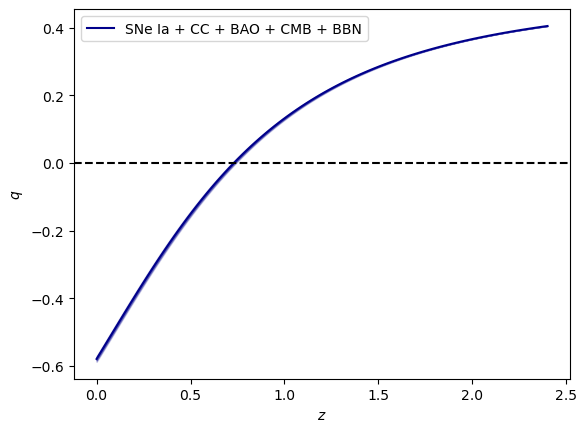

In [126]:
#deceleration param
def Hdot(z,Omr0,Omm0,Omk0,Oml0):
    res = -((4*Omr0*(1+z)**4 + 3*Omm0*(1+z)**3 + 2*Omk0*(1+z)**2)*H0_av**2)/2
    return res

def decel(z,Omr0,Omm0,Omk0,Oml0):
    q = -1 - Hdot(z,Omr0,Omm0,Omk0,Oml0)/Hubble(z,Omr0,Omm0,Omk0,Oml0)**2
    return q

y_decel = decel(x,m1,m2,m3,m4)
y_decel_plus = decel(x,m1+std1,m2+std2,m3+std3,m4+std4)
y_decel_minus = decel(x,m1-std1,m2-std2,m3-std3,m4-std4)
y_decel_pplus = decel(x,m1+2*std1,m2+2*std2,m3+2*std3,m4+2*std4)
y_decel_mminus = decel(x,m1-2*std1,m2-2*std2,m3-2*std3,m4-2*std4)

y_decel_late = decel(x,m1_late,m2_late,m3_late,m4_late)

plt.figure()
#plt.plot(x,y_decel_late,label='SNe Ia + CC + BAO',color='green',linestyle='--')
plt.plot(x,y_decel,label='SNe Ia + CC + BAO + CMB + BBN',color='darkblue')
plt.fill_between(x, y_decel_minus , y_decel_plus,color='darkblue', alpha=0.4)
plt.fill_between(x, y_decel_mminus , y_decel_pplus,color='darkblue', alpha=0.2)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('$z$')
plt.ylabel('$q$')
plt.legend()
plt.savefig('decel.pdf')
plt.show()